# 실행

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

np.warnings.filterwarnings('ignore')

# 데이터 준비
- 컬럼삭제 및 널값제거

In [4]:
df = pd.read_csv('use_df.csv')

In [5]:
df.columns

Index(['Unnamed: 0', 'Title', 'Series or Movie', 'COUNTRY', 'Release Date',
       'GENRE', 'VALUE', 'Genre_all', 'Tags', 'Languages', 'Hidden Gem Score',
       'Country Availability', 'Runtime', 'Director', 'Writer', 'Actors',
       'View Rating', 'IMDb Score', 'Rotten Tomatoes Score',
       'Metacritic Score', 'Awards Received', 'Awards Nominated For',
       'Boxoffice', 'Netflix Release Date', 'Production House', 'Summary',
       'IMDb Votes'],
      dtype='object')

In [6]:
df.drop(columns=['Genre_all','IMDb Votes','Metacritic Score','Rotten Tomatoes Score','View Rating','COUNTRY','Country Availability','Unnamed: 0','Tags','Actors','Languages','Director','Writer','Boxoffice','Production House','Summary','Awards Nominated For','Runtime','IMDb Score','Hidden Gem Score'],axis=1,inplace=True)
df.head(1)

,Title,Series or Movie,Release Date,GENRE,VALUE,Awards Received,Netflix Release Date
0,thequeensgambit,TV,2020-10-23,Drama,44867,96.0,2020-10-23


In [7]:
df.columns=(['Title', 'Type', 'Made_date', 'Genre', 'Value','Awards_Received','Netflix_date'])

Text(0.5, 1.0, 'MISSING VALUES')

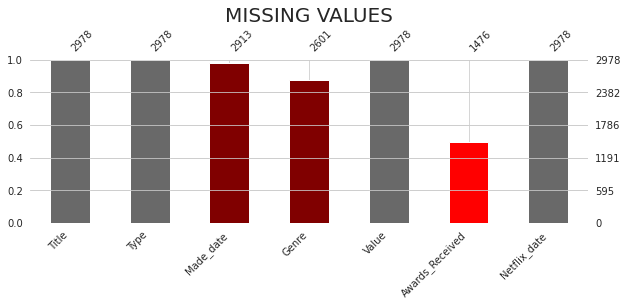

In [8]:
# 널값확인
import missingno as msno
color= ['dimgrey','dimgrey','maroon','maroon','dimgrey','red','dimgrey']
msno.bar(df,fontsize=10,color=color,figsize=(10,3))
plt.title('MISSING VALUES',fontsize=20)

In [9]:
df.isnull().sum()

Title                 0
Type                  0
Made_date            65
Genre               377
Value                 0
Awards_Received    1502
Netflix_date          0
dtype: int64

In [10]:
# 장르 부분은 나중에 필요시 널값 제거
#Release Date 컬럼 널값 행 제거
df.dropna(subset=['Made_date'], inplace=True)
# Awards_Received 컬럼 널값 0으로 수정
df.Awards_Received.fillna('0',inplace=True)

In [11]:
df.isnull().sum(), df.shape

(Title                0
 Type                 0
 Made_date            0
 Genre              322
 Value                0
 Awards_Received      0
 Netflix_date         0
 dtype: int64, (2913, 7))

In [12]:
netflix = df.copy()

In [13]:
netflix.duplicated().sum()
# 중복값 있으면 밑의 코드로 중복값 제거
# netflix_df = netflix.drop_duplicates(keep=False, inplace=False)

0

## 데이터 준비 - Netflix_date 인코딩
- Year, Month, Day와 요일로 새로운 컬럼 확장

In [14]:
netflix["Netflix_date"] = pd.to_datetime(netflix['Netflix_date'])
netflix['Year'] = netflix['Netflix_date'].dt.year
netflix['Month'] = netflix['Netflix_date'].dt.month
netflix['Day'] = netflix['Netflix_date'].dt.day

netflix.head(1)

,Title,Type,Made_date,Genre,Value,Awards_Received,Netflix_date,Year,Month,Day
0,thequeensgambit,TV,2020-10-23,Drama,44867,96,2020-10-23,2020,10,23


# 시각화
- made_Date와 Netflix_Date 를 통해 만든 새로운 컬럼으로 
- 3-1 뷰어수와 넷플릭스 릴리즈 데이트 대한 상관관계
- 3-1-2 넷플릭스 릴리즈 데이트를 해당날짜의 요일로 변경 후 요일별 컨텐츠 추가에 대한 viewporint와의 상관관계

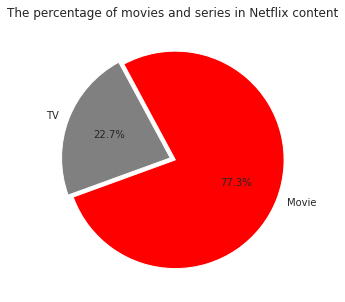

In [15]:
plt.figure(figsize=(10,5))
plt.title('The percentage of movies and series in Netflix content')
g = plt.pie(netflix.Type.value_counts(),explode=(0.025,0.025),
            labels=df.Type.value_counts().index, colors=['red','grey'],
            autopct='%1.1f%%', startangle=200)
plt.show()

### 가설
- 귀무가설 : Netflix Release date 는 viewpoint에 영향이 있다
- 대립가설 : Netflix Release date 는 viewpoint에 영향이 없다

In [16]:
# 무비, 시리즈 분리
Movie_df = netflix[netflix['Type']=='Movie']
Series_df = netflix[netflix['Type']=='TV']

In [17]:
Movie_df.head(1)

,Title,Type,Made_date,Genre,Value,Awards_Received,Netflix_date,Year,Month,Day
1,365days,Movie,2020-06-07,Romance,42149,0,2020-04-02,2020,4,2


In [18]:
Series_df.head(1)

,Title,Type,Made_date,Genre,Value,Awards_Received,Netflix_date,Year,Month,Day
0,thequeensgambit,TV,2020-10-23,Drama,44867,96,2020-10-23,2020,10,23


#### 컨텐츠 추가 시기확인

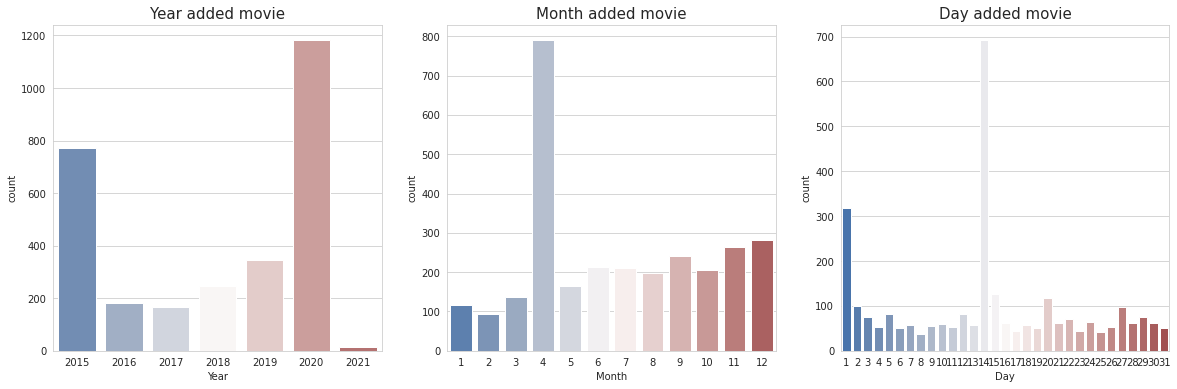

In [19]:
fig, ax = plt.subplots(1,3, figsize=(20,6))
# 컨텐츠 추가 년,월,일별 통계
# Year
sns.countplot('Year', data=netflix, palette='vlag', ax=ax[0])
ax[0].set_title('Year added movie',
            fontdict={'fontsize':15})

# Month
sns.countplot('Month', data=netflix, palette='vlag', ax=ax[1])
ax[1].set_title('Month added movie',
            fontdict={'fontsize':15})

# Day
sns.countplot('Day', data=netflix, palette='vlag', ax=ax[2])
ax[2].set_title('Day added movie',
            fontdict={'fontsize':15})

plt.show()

- Year : 2015년과 2020년에 평균흐름보다 3배 가량의 컨텐츠 추가량이 보여진다
- Month : 년초보단 하반기로 갈수록 점진적으로 많이 늘리는 흐름을 보이고, 4월은 다른달보다 컨텐츠 추가가 월등하게 높다
- Day : 흐름을 고르게 보이고 있으나,1일과 14 일은 다른 날보다 많은 컨텐츠를 추가했다

### 년, 월, 일 별 컨텐츠 추가날짜를 통한 Viewpoint 분석

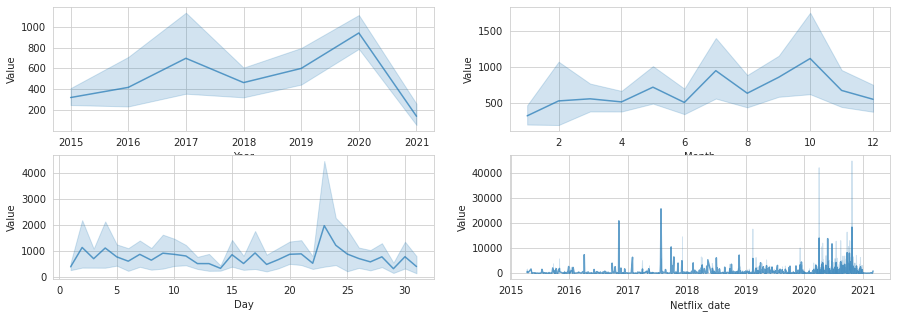

In [20]:
fig, ax = plt.subplots(2,2, figsize=(15,5))

sns.lineplot(x='Year', y=netflix['Value'], data=netflix, ax=ax[0,0], alpha=0.7)
sns.lineplot(x='Month', y=netflix['Value'], data=netflix, ax=ax[0,1], alpha=0.7)
sns.lineplot(x='Day', y=netflix['Value'], data=netflix, ax=ax[1,0], alpha=0.7)
sns.lineplot(x='Netflix_date', y=netflix['Value'], data=netflix, ax=ax[1,1], alpha=0.7)

plt.show()

In [21]:
netflix.corr()

,Value,Year,Month,Day
Value,1.000000,0.108651,0.044993,0.013330
Year,0.108651,1.000000,0.330389,0.065654
Month,0.044993,0.330389,1.000000,0.008790
Day,0.013330,0.065654,0.008790,1.000000


- Year : 2020년에 추가된 컨텐츠와 2017년에 추가된 컨텐츠가 다른 년도에 추가된 컨텐츠보다 viewpoint 가 월등히 높음을 확인할 수 있다. 그럼 20년과 17년에 컨텐츠를 많이 출시 했을지 앞의 년도별 컨텐츠 추가량 그래프를 확인한 결과 20년은 굉장히 많은 컨텐츠를 출시 했지만 17년의 출시한 컨텐츠의 양은 평균 이하수준으로 확인된다

- month : 10월과 7월에 추가한 컨텐츠가 다른 월에 출시한 컨텐츠보다 viewpoint 가 높음을 확인할 수 있다. 그럼 10월과 7월에 컨텐츠를 과도하게 많이 출시한건 아닐까? 앞서 분석한 월별 컨텐츠 추가량 그래프를 확인해보면 10월과 7월은 그다지 많이 출시하지 않았다. 

- Day : 매월 23-24일 사이에 출시된 컨텐츠의 viewpoint가 다른 일에 출시한 viewpoint 보다 월등히 높다. 앞서 day별 추가된 컨텐츠 량을 확인해 보면 1일과 14일에 추가된 컨텐츠의 양이 굉장히 높은걸로 확인된다.

- 총평 :넷플릭스 출시 시기와 value(viewpoint)를 한눈에 볼수 있는 그래프가 있다 16년-17년 사이에 출시된 컨텐츠와 20년에 출시된 컨텐츠 들이 대체로 많은 viewpoint 를 기록 중이며, 출시가 빨리 됬다고 뷰포인트가 높은것은 아니다 라는 결론과 출시일정과 상관관계가 적다는 결론을 낼수 있다

### 그럼 여기서  조금 방향을 틀어보자. 어느 요일에 더 많은 컨텐츠를 출시 했는가?

In [22]:
#dayofweek(요일)컴럼 추가/ head 5개 값 확인 완료
netflix['dayofweek'] = netflix['Netflix_date'].dt.day_name()
netflix.head()

,Title,Type,Made_date,Genre,Value,Awards_Received,Netflix_date,Year,Month,Day,dayofweek
0,thequeensgambit,TV,2020-10-23,Drama,44867,96,2020-10-23,2020,10,23,Friday
1,365days,Movie,2020-06-07,Romance,42149,0,2020-04-02,2020,4,2,Thursday
2,emilyinparis,TV,2020-10-02,Drama,27138,1,2020-10-02,2020,10,2,Friday
3,lucifer,TV,2016-01-25,Superhero,25729,0,2017-07-24,2017,7,24,Monday
4,theumbrellaacademy,TV,2019-02-15,Superhero,23480,7,2019-02-15,2019,2,15,Friday


In [23]:
import plotly.express as px
day_df = netflix['dayofweek'].value_counts().reset_index()

fig = px.pie(day_df, values='dayofweek', names='index',color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label',
                  marker = dict(line = dict(color = 'white', width = 1)))
fig.show()

In [24]:
month_day=pd.crosstab(netflix['Month'],netflix['dayofweek'],margins=True).style.background_gradient(cmap='PuBu')
month_day

dayofweek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,All
Month,,,,,,,,
1,39,7,13,8,14,10,26,117
2,25,9,10,2,20,9,18,93
3,46,15,10,12,22,13,18,136
4,39,27,9,17,24,627,47,790
5,41,11,18,17,28,23,26,164
6,41,38,28,16,40,17,34,214
7,61,21,25,22,25,8,48,210
8,42,14,41,31,29,12,28,197
9,37,26,35,32,21,45,44,240


 - 결과를 보면 넷플릭스의 컨텐츠 출시 요일은 목요일과 금요일이 압도적이다. 그럼 다음 그래프에선 출시 요일별 viewpoint를 한번 보도록하자

In [46]:
num = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
netflix['num'] = 0
for i in range(len(netflix['dayofweek'])):
    if netflix['dayofweek'].iloc[i] in num:
        netflix['num'].iloc[i] = num.index(netflix['dayofweek'].iloc[i])

netflix = netflix.sort_values('num')

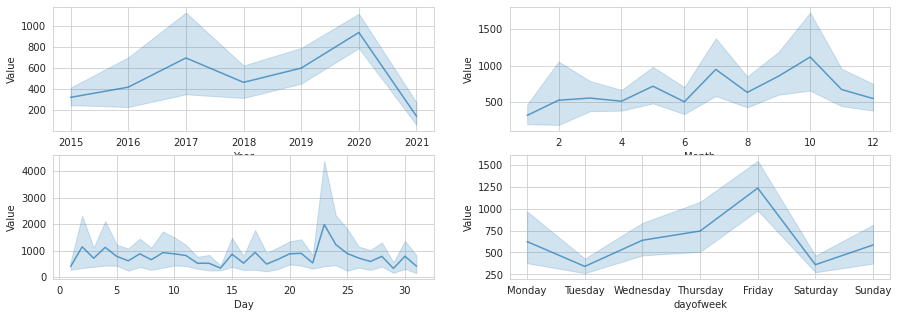

In [49]:
fig, ax = plt.subplots(2,2, figsize=(15,5))

sns.lineplot(x='Year', y=netflix['Value'], data=netflix, ax=ax[0,0], alpha=0.7)
sns.lineplot(x='Month', y=netflix['Value'], data=netflix, ax=ax[0,1], alpha=0.7)
sns.lineplot(x='Day', y=netflix['Value'], data=netflix, ax=ax[1,0], alpha=0.7)
sns.lineplot(x=netflix['dayofweek'] , y=netflix['Value'], data=netflix, ax=ax[1,1], alpha=0.7)

plt.show()

총평 : 넷플릭스 출시 시기와 value(viewpoint)를 한눈에 볼수 있는 그래프가 있다 
16년-17년 사이에 출시된 컨텐츠와 20년에 출시된 컨텐츠 들이 대체로 많은 viewpoint 를 기록 중이며, 출시가 빨리 됬다고 뷰포인트가 높은것은 아니다 라는 결론과 출시일정과 상관관계가 적다는 결론을 낼수 있고,
요일에 따른 viewpoint를 살펴보면 컨텐츠 출시는 대체적으로 화요일에 컨텐츠 출시를 많이 하고 있지만 목요일과 금요일에 출시한 컨텐츠들이 대체적으로 viewpoint가 높은것으로 나타난다